# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [ ]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/nlp/hw2")
sys.path.append("/content/drive/MyDrive/nlp/hw2/hw2-part1-bow_nli")
sys.path.append("/content/drive/MyDrive/nlp/hw2/pyfiles")
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/nlp/hw2',
 '/content/drive/MyDrive/nlp/hw2/hw2-part1-bow_nli',
 '/content/drive/MyDrive/nlp/hw2/pyfiles']

In [ ]:
cd /content/drive/MyDrive/nlp/hw2/

/content/drive/MyDrive/nlp/hw2


In [ ]:
ls

data/  hw2-part1-bow_nli/  hw2-part2-nlm.ipynb  hw2-part3-nmt.ipynb  pyfiles/


In [ ]:
# Import custom modules
from pyfiles import bleu_score
from pyfiles import global_variables
from pyfiles import nmt_dataset
from pyfiles import nnet_models_new

In [ ]:
#torch.cuda.is_available()
global_variables.device

device(type='cuda')

---
### 1 Dataset (6 pts)
#### Data Processing

In [ ]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/hw2-part1-bow_nli/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

**Coding 1: finish `build_vocab` function** (2 pts)


In [ ]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices

    vocab_counts = {}
    for sentence in hypo_tokens + prem_tokens:
        for word in sentence:
            if word not in vocab_counts:
                vocab_counts[word] = 1
            else:
                vocab_counts[word] += 1
    # sort the dict with counts in descending order
    vocab_counts = dict(sorted(vocab_counts.items(), key = lambda x: x[1], reverse = True))
    id2token = ['', ''] + list(vocab_counts.keys())[:max_vocab_size]
    
    token2id = {}
    for token in id2token:
        token2id[token] = id2token.index(token)

    return token2id, id2token

**Coding 2: finish `token2index` function** (2 pts)

In [ ]:
def token2index(tokens_data):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)

    indices_data = []
    for sentence in tokens_data:
      sentence_index = []
      for token in sentence:
        if token in token2id:
          sentence_index.append(token2id[token])
        else:
          sentence_index.append(UNK_IDX)
      indices_data.append(sentence_index)

    return indices_data


In [ ]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)
hypo_data_indices_train = token2index(hypo_data_tokens_train)
prem_data_indices_train = token2index(prem_data_tokens_train)
hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)  

#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [ ]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=0)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=0)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [ ]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [ ]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val, max_sentence_length)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (code from the labs may be helpful). (8 pts)

In [ ]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        self.reduce = reduce
        # 1. Embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = PAD_IDX)
        # 2. Linear Layers
        if self.reduce == 'concat':
            self.linear = nn.Linear(emb_dim * 2, n_out)
        else:
            self.linear = nn.Linear(emb_dim, n_out)

    def forward(self, data_hypo, length_hypo, data_prem, length_prem):
        """
        @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents 
        a review that is represented using n-gram index. Note that they are padded to have same length.
        @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial 
        (excludes padding) length of each sentences in data_hypo.
        @param data_prem: matrix of size (batch_size, max_sentence_length).
        @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial 
        (excludes padding) length of each sentences in data_prem.
        """
        # TODO:
        # word embedding
        # combine to sentence
        hypo_embeddings = self.embedding(data_hypo).sum(dim = 1) / length_hypo.unsqueeze(1)
        prem_embeddings = self.embedding(data_prem).sum(dim = 1) / length_hypo.unsqueeze(1)
    
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if reduce == 'concat':
            embeddings_all = torch.cat((hypo_embeddings, prem_embeddings), dim = 1)
        if reduce == 'sum':
            embeddings_all = hypo_embeddings + prem_embeddings
        if reduce == 'hadamard':
            embeddings_all = torch.mul(hypo_embeddings, prem_embeddings)
        
        # hidden layers 
        out = self.linear(embeddings_all)
        return out

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [ ]:
# training parameters
num_epochs = 10 
BATCH_SIZE = 1024

In [ ]:
# TODO:
# finish DataLoader
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, collate_fn = newsgroup_collate_func,
                          shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, collate_fn = newsgroup_collate_func,
                        shuffle = True, num_workers = 0)


**Coding 5: finish training and validation** (4 pts)

The following incomplete code can get you started on your train loop. Feel free to modify the function signature to pass any arguments needed for the training.

In [ ]:
# training:
def train(model, criterion, optimizer):
    train_losses = [] # record training loss after every epoch
    val_losses = [] # record validation loss after every epoch
    train_accs = [] # record training accuracy after every epoch
    val_accs = [] # record validation accuracy after every epoch

    train_losses_batch = [] # record training loss after every batch
    val_losses_batch = [] # record validation loss after every batch
    train_accs_batch = [] # record training accuracy after every batch
    val_accs_batch = [] # record validation accuracy after every batch

    for epoch in range(num_epochs):

        # Put model into training mode.
        model.train()
        # initiate lists to store stats for every batch in this epoch
        train_losses_temp = []
        train_accs_temp = []

        for data_hypo_train, length_hypo_train, data_prem_train, length_prem_train, labels_train in train_loader:

            optimizer.zero_grad()

            # Compute the predicted log-probabilities
            logits = model(data_hypo_train, length_hypo_train, data_prem_train, length_prem_train)
            
            # Compute the loss
            train_loss = criterion(logits, labels_train)

            # prediction of labels
            train_preds = torch.argmax(logits, dim = 1)
            
            # Back-propagate the gradients to the parameters
            train_loss.backward()
            # Apply the gradient updates to the parameters
            optimizer.step()
            # Record the loss
            train_losses_temp.append(train_loss.item())
            correct = (train_preds == labels_train).sum()
            accuracy = correct/len(labels_train)
            train_accs_temp.append(accuracy)

        train_losses_batch += train_losses_temp
        train_accs_batch += train_accs_temp

        train_losses.append(np.mean(train_losses_temp))
        train_accs.append(np.mean(train_accs_temp))

        # Recompute the loss in evaluation mode, and record it.
        model.eval()
        # initiate lists to store val stats for every batch in this epoch
        val_losses_temp = []
        val_accs_temp = []
        with torch.no_grad():
            for data_hypo_val, length_hypo_val, data_prem_val, length_prem_val, labels_val in val_loader:
                val_logits = model(data_hypo_val, length_hypo_val, data_prem_val, length_prem_val)
                val_loss = criterion(val_logits, labels_val)
                val_preds = torch.argmax(val_logits, dim = 1)

                # Record the loss
                val_losses_temp.append(val_loss.item())
                correct = (val_preds == labels_val).sum()
                accuracy = correct / len(labels_val)
                val_accs_temp.append(accuracy)

            val_losses_batch += val_losses_temp
            val_accs_batch += val_accs_temp

            val_losses.append(np.mean(val_losses_temp))
            val_accs.append(np.mean(val_accs_temp))
    # dictionary to store outputs
    out = {"train_losses": train_losses, "val_losses": val_losses, \
           "train_accs": train_accs, "val_accs": val_accs, \
           "train_losses_batch": train_losses_batch, "val_losses_batch": val_losses_batch, \
           "train_accs_batch": train_accs_batch, "val_accs_batch": val_accs_batch, \
           "val_preds": val_preds, "val_labels": labels_val,
           "val_data_hypo": data_hypo_val, "val_data_prem": data_prem_val
           }
    return out


#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
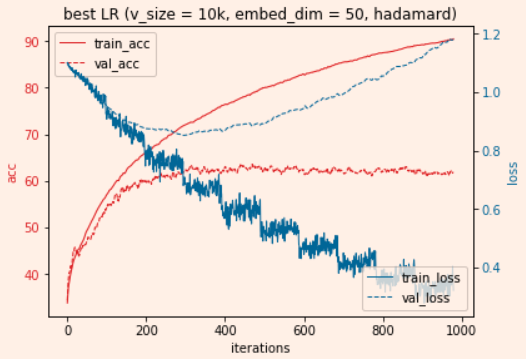

The following function may be useful to you to accomplish this, but you are also welcome to modify it or write your own plotting code.

In [ ]:
def plot_over_training(per_epoch_metrics, title_name):
  """Utility function to plot train/val accuracies and losses.

  @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
  @param title_name: String to show on the plot title.
  """
  t = np.arange(0, len(per_epoch_metrics['train_accs']))
  train_acc = per_epoch_metrics['train_accs']
  val_acc = per_epoch_metrics['val_accs']
  train_loss = per_epoch_metrics['train_losses']
  val_loss = per_epoch_metrics['val_losses']

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('acc', color=color)
  ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
  ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper left')
  ax2 = ax1.twinx() 

  color = 'tab:blue'
  ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
  ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
  ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.legend(loc='lower right')
  fig.tight_layout() 
  plt.title(title_name)
  plt.show()

In [ ]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dims = [50, 100]
# 3. reduce : ["sum", "hadamard", "concat"]
reduces = ["sum", "hadamard"]
# 4. learning_rate
learning_rates = [0.01, 0.05]

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

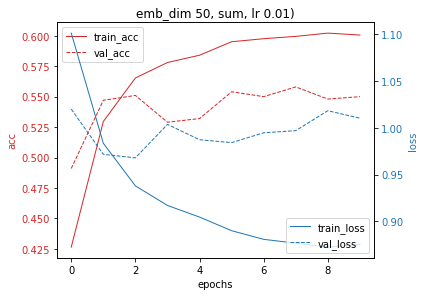

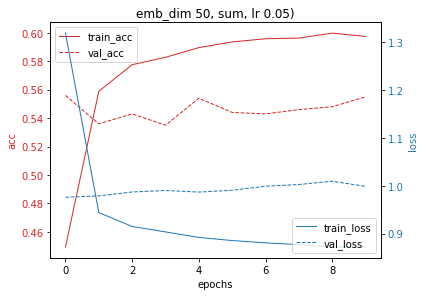

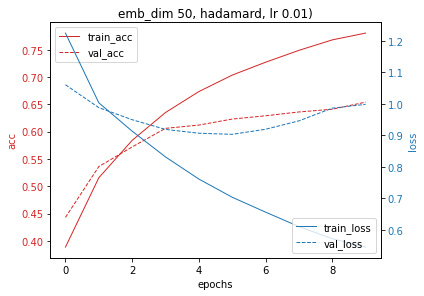

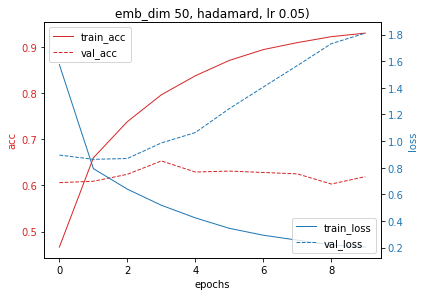

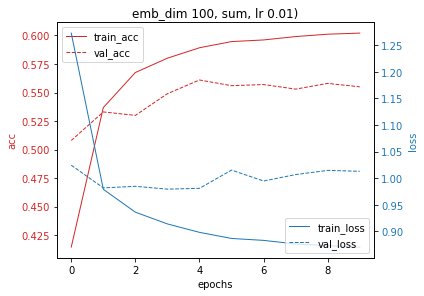

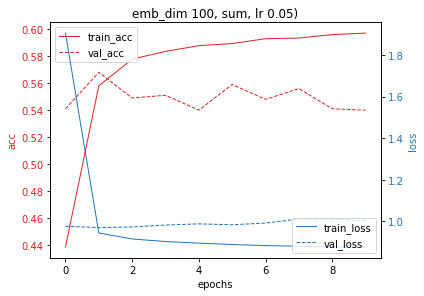

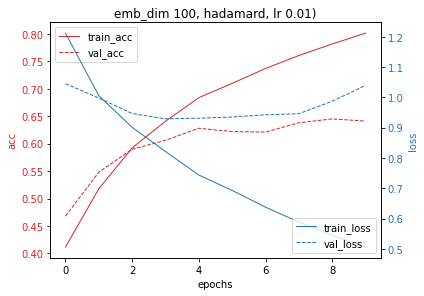

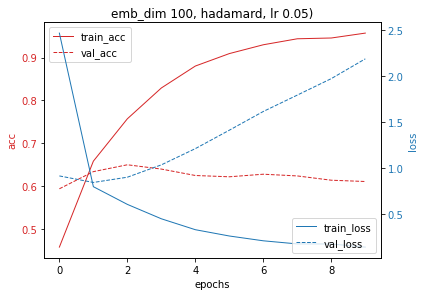

In [ ]:
best_valacc = 0
best_param = ""
best_val_preds = ""
best_val_labels  = ""
best_val_hypo = ""
best_val_prem = ""
for emb_dim in emb_dims:
    for reduce in reduces:
        for learning_rate in learning_rates:
            model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
            # Criterion and Optimizer
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
            # train the model
            train_outputs = train(model, criterion, optimizer)
            # plot
            title_name = "emb_dim {}, {}, lr {})".format(emb_dim, reduce, learning_rate)
            plot_over_training(train_outputs, title_name)
            # update best val accuracy
            if np.max(train_outputs["val_accs"]) > best_valacc:
                best_valacc = np.max(train_outputs["val_accs"])
                best_param = "emb_dim {}, {}, lr {})".format(emb_dim, reduce, learning_rate)
                best_val_preds = train_outputs["val_preds"]
                best_val_labels = train_outputs["val_labels"]
                best_val_hypo = train_outputs["val_data_hypo"]
                best_val_prem =  train_outputs["val_data_prem"]

1. with a smaller learning rate (0.01), the validation accuracy increases even after 8 epochs; however, with a larger learning rate (0.05), validation accuracy tends to decrease after a few epochs.
2. increasing the embedding dimensions slightly increases the validation losses
3. changing the interaction type from sum to element wise product increases the validation accuracy 

**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

In [ ]:
# see code above for selection of best model
print("best model is", best_param, "with validation accuracy of", best_valacc)

best model is emb_dim 50, hadamard, lr 0.01) with validation accuracy of 0.654


**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [ ]:
correct_pred_index = []
incorrect_pred_index = []
labels = {0: 'neutral', 
          1: 'entailment', 
          2: 'contradiction'}

for i in range(len(best_val_preds)):
    if best_val_preds[i] != best_val_labels[i]:
        incorrect_pred_index.append(i)
    else:
        correct_pred_index.append(i)

# randomly choosing 3 examples of correct and incorrect predictions
print("3 correct examples:")
for exp_inx in correct_pred_index[36: 39]:
    premise = ""
    for id in best_val_prem[exp_inx]:
        premise += id2token[int(id)]
        premise += " "
    print("correct premise:", premise)
    hypothesis = ""
    for id in best_val_hypo[exp_inx]:
        hypothesis += id2token[int(id)]
        hypothesis += " "
    print("correct hypothesis:", hypothesis)
    print("correct prediction:", labels[int(best_val_preds[exp_inx])])
    print("correct label:", labels[int(best_val_labels[exp_inx])])

print("\n")
print("3 incorrect examples:")
for exp_inx in incorrect_pred_index[36: 39]:
    premise = ""
    for id in best_val_prem[exp_inx]:
        premise += id2token[int(id)]
        premise += " "
    print("incorrect premise:", premise)
    hypothesis = ""
    for id in best_val_hypo[exp_inx]:
        hypothesis += id2token[int(id)]
        hypothesis += " "
    print("incorrect hypothesis:", hypothesis)
    print("incorrect prediction:", labels[int(best_val_preds[exp_inx])])
    print("incorrect label:", labels[int(best_val_labels[exp_inx])])

3 correct examples:
correct premise: a boy toddler play outside on a clothes rack full of tied dye shirts       
correct hypothesis: a toddler is enjoying the sunny weather              
correct prediction: neutral
correct label: neutral
correct premise: a black dog is running through a snow covered area while holding something green in his mouth    
correct hypothesis: the dog runs along outdoors                
correct prediction: entailment
correct label: entailment
correct premise: a little kid is jumping off a brick balcony            
correct hypothesis: a little boy is jumping around and falls off a balcony          
correct prediction: neutral
correct label: neutral


3 incorrect examples:
incorrect premise: a man in a white shirt waves his hand under a white and blue umbrella      
incorrect hypothesis: a man sitting under an umbrella on the beach is waving at others        
incorrect prediction: contradiction
incorrect label: neutral
incorrect premise: a man wearing a white s

1. The first incorrect label prediction might be due to new information such as "sitting" and "beach". While they are not relavant and cause no contradiction, the model might have decided that the differences between the two sentences are significant enough. 
2. The second example differs in the description of the man: wearing a white shirt versus in a band, which are not contradicting to each other. However, the model could have put more weight on the descriptions rather than the noun and the verb even though the rest of the sentences are the same.
3. The third inccorect prediction could be due to the model's incapability of capturing the contradiction between "take photo" and "whithout cameras". As long as cameras and photos have similar meanings, negation isn't handled very well in this model. 